In [1]:
import json
from typing import Dict, List, Tuple
from urllib.request import urlopen

import arviz
import numpy as np
import pandas as pd
import pymc as pm

In [21]:
    # Define which columns might need dtype conversion or special handling. Adjust based on the sample and expected data types.


# Read the CSV file
df = pd.read_csv("../data/popstar_sondagens_data.csv", encoding='latin1',na_values=[' '])
columns_to_convert = [col for col in df.columns if 'sondagens' in col]
df[columns_to_convert] = df[columns_to_convert].astype(float)
df.dropna(subset='PS nas sondagens', inplace=True)

#filter only the columns that we want to use, instituto, N, dia, sondagens
columns = ['Instituto', 'N', 'Dia'] + [col for col in df.columns if 'sondagens' in col and 'PDR' not in col] + ['PSDCDS']
df = df[columns]    

df = df.rename(columns={'Dia': 'date', 'Instituto': 'pollster', 'PS nas sondagens': 'PS', 'PSD nas sondagens': 'PSD', 'BE nas sondagens': 'BE', 'CDU nas sondagens': 'CDU', 'CDS nas sondagens': 'CDS', 'Livre nas sondagens': 'L', 'PSDCDS': 'AD', 'N': 'sample_size'})
df[['IL', 'CH']] = 0
df

,pollster,sample_size,date,PS,PSD,BE,CDS,CDU,L,AD,IL,CH
0,Eurosondagem,1010.0,6/28/2011,0.250000,0.408000,0.048000,0.136000,0.077000,NaN,NaN,0,0
10,Aximage,600.0,7/8/2011,0.247423,0.432990,0.060825,0.106186,0.077320,NaN,NaN,0,0
21,Eurosondagem,1022.0,7/19/2011,0.263000,0.400000,0.051000,0.131000,0.080000,NaN,NaN,0,0
63,Eurosondagem,1025.0,8/30/2011,0.269000,0.396000,0.055000,0.125000,0.084000,NaN,NaN,0,0
74,Aximage,600.0,9/10/2011,0.268449,0.437433,0.034225,0.075936,0.096257,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1552,Marktest,1607.0,9/27/2015,0.290000,NaN,0.087000,NaN,0.093000,0.008,0.410,0,0
1553,Intercampus,1008.0,9/28/2015,0.316000,NaN,0.078000,NaN,0.080000,NaN,0.388,0,0
1554,Catolica,3137.0,9/29/2015,0.331000,NaN,0.071000,NaN,0.096000,NaN,0.381,0,0
1555,Intercampus,1013.0,9/30/2015,0.329000,NaN,0.079000,NaN,0.088000,NaN,0.372,0,0


In [16]:
political_families = [
        'PS', 'CH', 'IL', 'BE', 'CDU', 'PAN', 'L', 'AD'
    ]

In [17]:
polls_df = pd.read_csv('/workspaces/models/data/polls_renascenca.tsv', sep='\t', na_values='—')

#rename columns
polls_df = polls_df.rename(columns={'DATA': 'date', 'ORIGEM': 'pollster', 'ps': 'PS', 'psd': 'PSD', 'chega': 'CH', 'iniciativa liberal' : 'IL', 'bloco de esquerda': 'BE', 'CDU PCP-PEV': 'CDU', 'PAN': 'PAN', 'CDS': 'CDS', 'livre': 'L', 'aliança democrática': 'AD', 'AMOSTRA': 'sample_size'})

for col in ['PS', 'PSD', 'CH', 'IL', 'BE', 'CDU', 'PAN', 'CDS', 'L', 'AD']:
    polls_df[col] = polls_df[col].str.replace('%', '').astype(float) / 100

In [11]:
polls_df['AD'] = polls_df['AD'].fillna(polls_df['PSD'] + polls_df['CDS'])
#drop psd and cds columns
polls_df = polls_df.drop(columns=['PSD', 'CDS'])
#fill na with 0
polls_df = polls_df.fillna(0)
polls_df


,date,pollster,sample_size,PS,CH,IL,BE,CDU,PAN,L,AD
0,2016-01-03,Eurosondagem,1016,0.333,0.000,0.000,0.101,0.085,0.015,0.000,0.396
1,2016-01-04,Aximage,602,0.346,0.000,0.000,0.123,0.075,0.000,0.000,0.401
2,2016-01-30,Aximage,606,0.360,0.000,0.000,0.102,0.069,0.000,0.000,0.398
3,2016-02-07,Eurosondagem,1010,0.336,0.000,0.000,0.100,0.083,0.013,0.000,0.400
4,2016-03-02,Aximage,609,0.344,0.000,0.000,0.115,0.067,0.000,0.000,0.390
...,...,...,...,...,...,...,...,...,...,...,...
279,2024-02-24,CESOP-UCP,1207,0.267,0.186,0.053,0.041,0.027,0.014,0.041,0.333
280,2024-02-25,Duplimétrica-IPESPE,600,0.253,0.169,0.060,0.048,0.024,0.012,0.036,0.325
281,2024-02-26,Aximage,809,0.332,0.167,0.039,0.066,0.040,0.020,0.017,0.297
282,2024-02-28,Duplimétrica-IPESPE,600,0.265,0.169,0.060,0.048,0.024,0.012,0.036,0.337


In [13]:
from datetime import datetime
election_dates = [
    '2024-03-10',
    '2022-01-30',
    '2019-10-06',
    '2015-10-04',
    '2011-06-05',
    '2009-09-27',
    '2005-02-20',
    '2002-03-17',
]

#convert election dates to datetime
election_dates = [datetime.strptime(date, '%Y-%m-%d') for date in election_dates]
polls_df['election_date'] = polls_df.apply(find_closest_election_date, axis=1)



In [14]:
polls_df

,date,pollster,sample_size,PS,CH,IL,BE,CDU,PAN,L,AD,election_date
0,2016-01-03,Eurosondagem,1016,0.333,0.000,0.000,0.101,0.085,0.015,0.000,0.396,2019-10-06
1,2016-01-04,Aximage,602,0.346,0.000,0.000,0.123,0.075,0.000,0.000,0.401,2019-10-06
2,2016-01-30,Aximage,606,0.360,0.000,0.000,0.102,0.069,0.000,0.000,0.398,2019-10-06
3,2016-02-07,Eurosondagem,1010,0.336,0.000,0.000,0.100,0.083,0.013,0.000,0.400,2019-10-06
4,2016-03-02,Aximage,609,0.344,0.000,0.000,0.115,0.067,0.000,0.000,0.390,2019-10-06
...,...,...,...,...,...,...,...,...,...,...,...,...
279,2024-02-24,CESOP-UCP,1207,0.267,0.186,0.053,0.041,0.027,0.014,0.041,0.333,2024-03-10
280,2024-02-25,Duplimétrica-IPESPE,600,0.253,0.169,0.060,0.048,0.024,0.012,0.036,0.325,2024-03-10
281,2024-02-26,Aximage,809,0.332,0.167,0.039,0.066,0.040,0.020,0.017,0.297,2024-03-10
282,2024-02-28,Duplimétrica-IPESPE,600,0.265,0.169,0.060,0.048,0.024,0.012,0.036,0.337,2024-03-10


In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

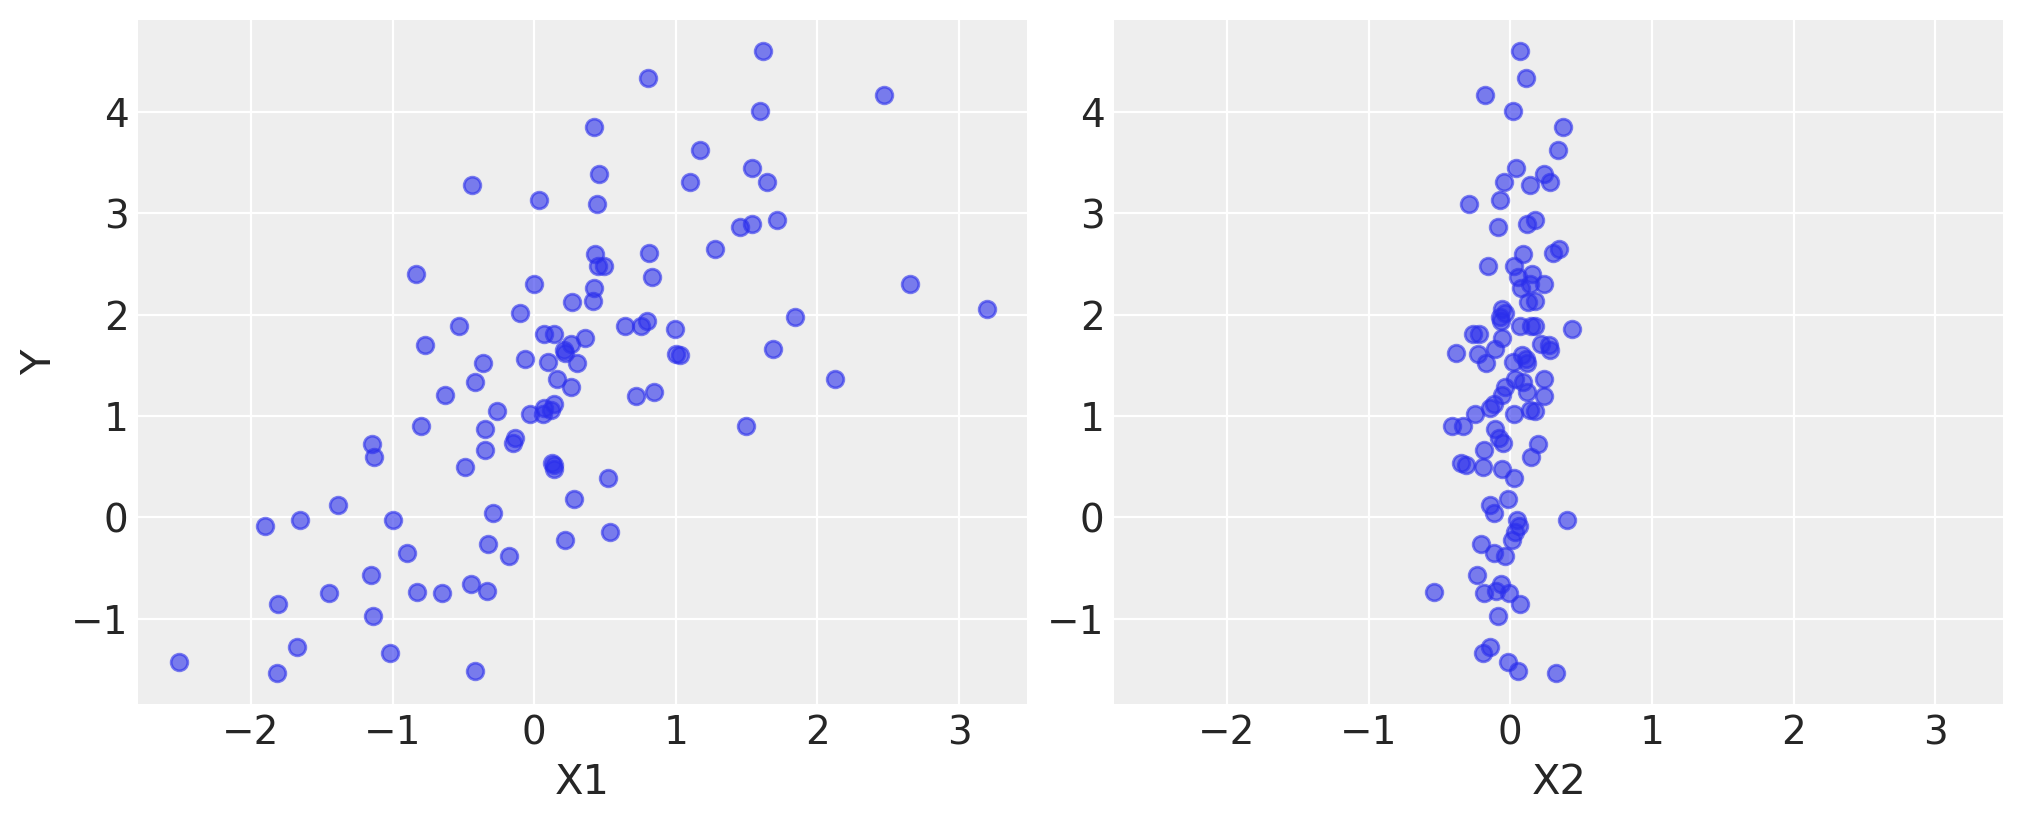

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [6]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.4


In [13]:
basic_model = pm.Model()

with basic_model:
    #constant data for y
    Y_data = pm.ConstantData("Y_data", Y)
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y_data)

In [14]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [10]:
idata


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

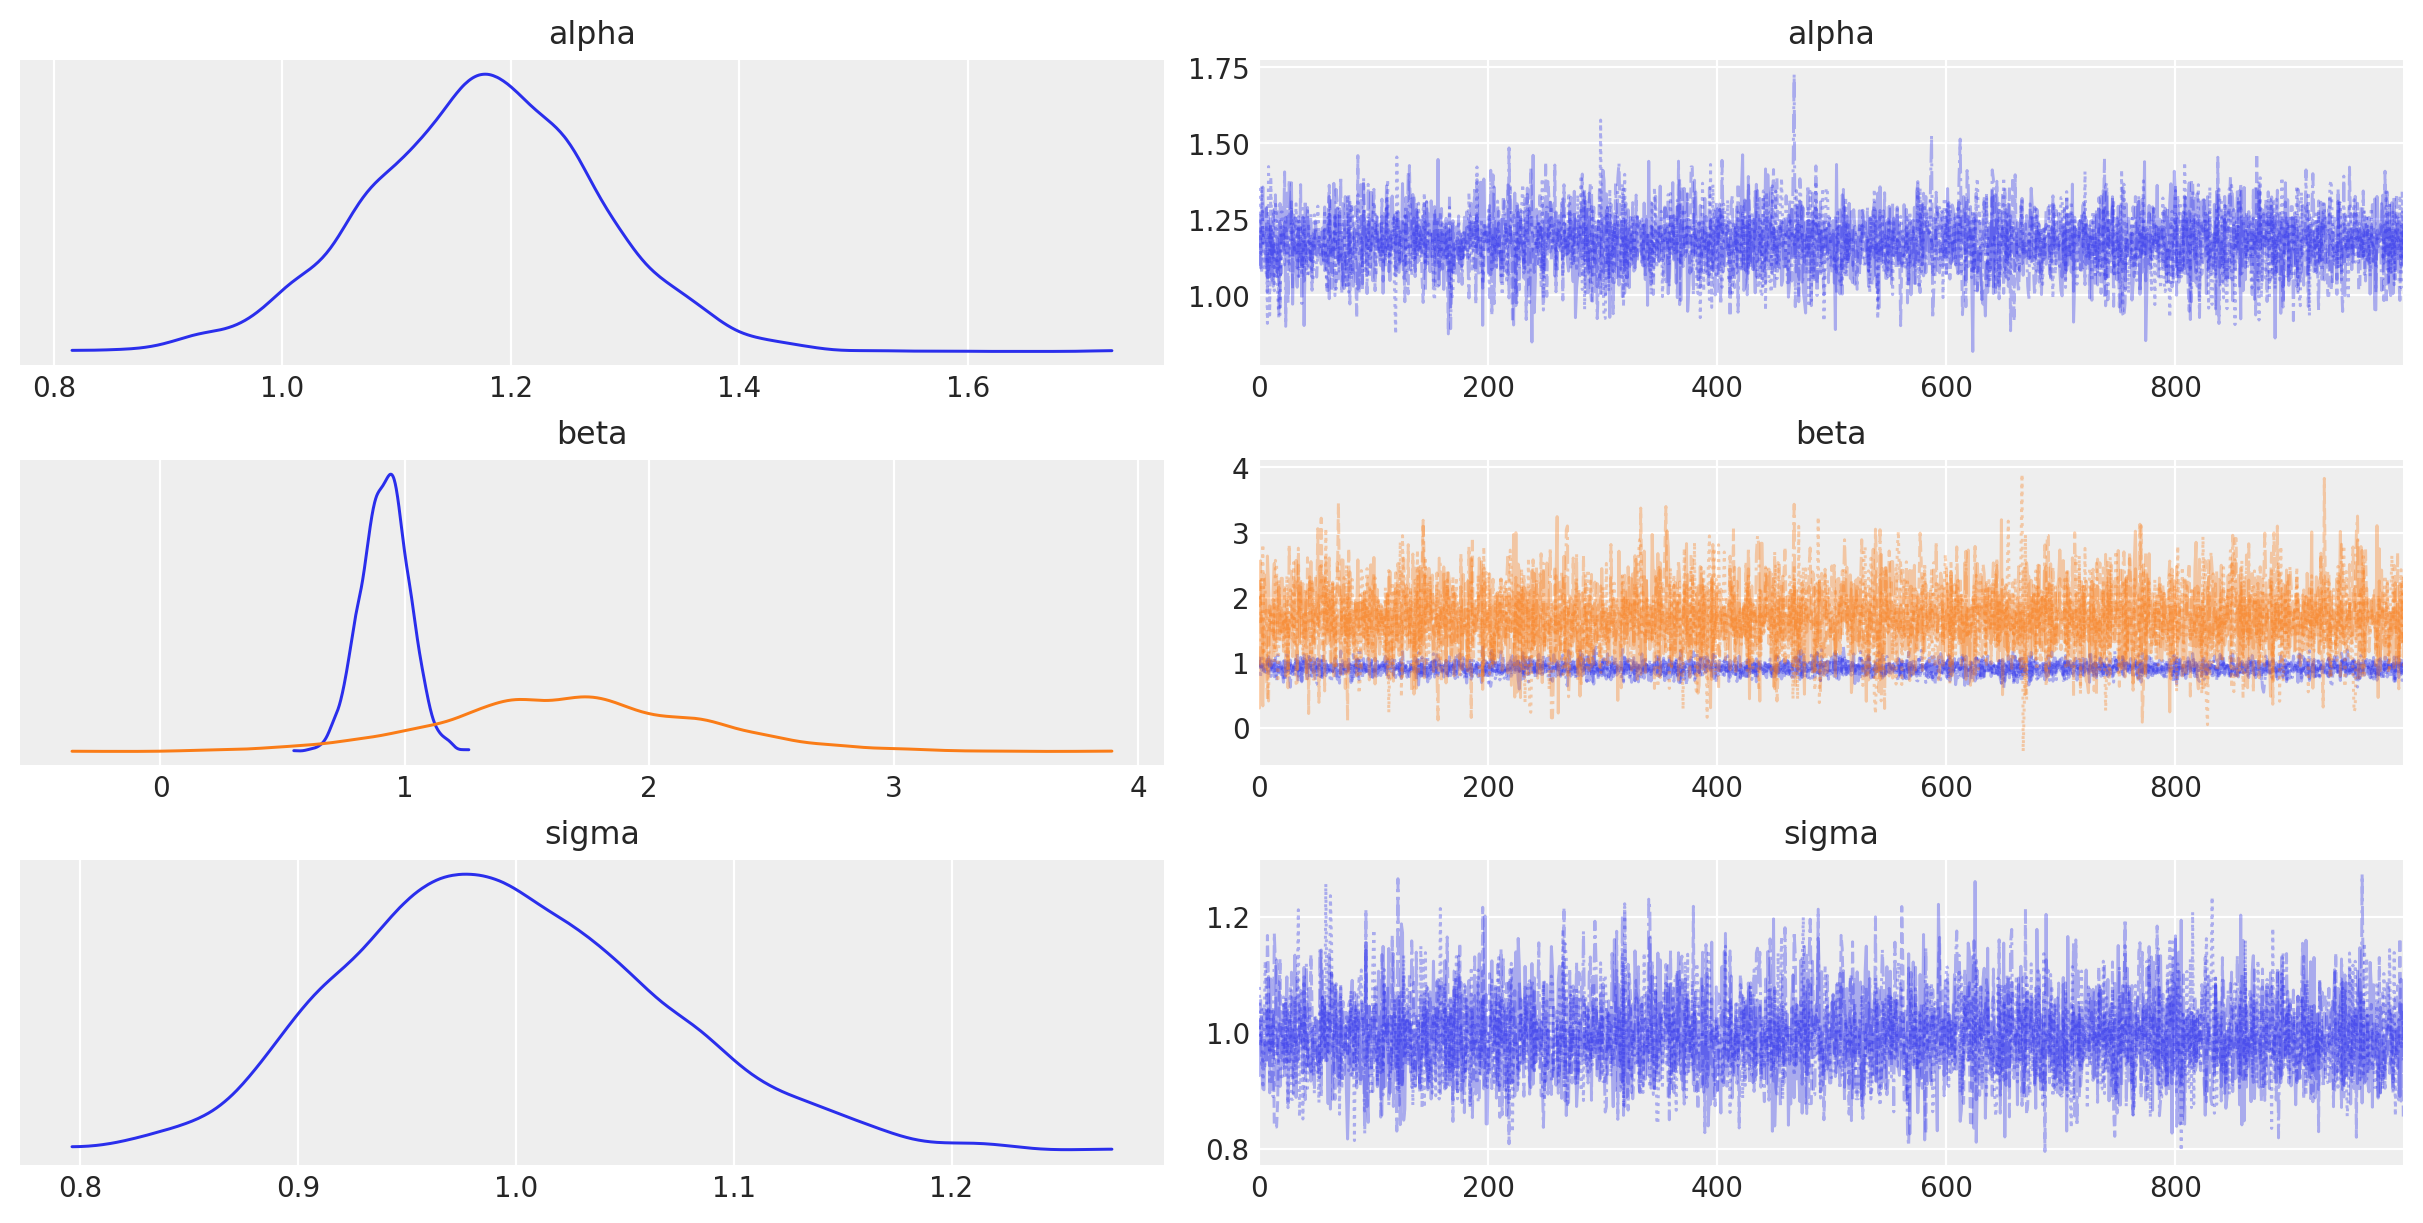

In [11]:
az.plot_trace(idata, combined=True);